In [69]:
#import library 
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ProxseqClasses as PC
import celltypist
from celltypist import models
from matplotlib.pyplot import rc_context

In [2]:
print(f"celltypist=={celltypist.__version__}")

celltypist==1.5.1


In [3]:
#Load data 
#RNA data 
adata = sc.read_10x_mtx('pbmc_10x',cache=True)
adata.var_names_make_unique()
#check data structure
adata

AnnData object with n_obs × n_vars = 12577 × 36601
    var: 'gene_ids', 'feature_types'

In [4]:
#Anndata exploration 
adata.obs.head()

""
AAACCCAAGTTAACGA-1
AAACCCAAGTTACTCG-1
AAACCCACAACCGTGC-1
AAACCCACAGCTGTTA-1
AAACCCACAGGATCTT-1


In [5]:
#variable/gene metadata
adata.var.head()

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression


In [5]:
#gene names
adata.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)

In [7]:
adata.X

<12577x36601 sparse matrix of type '<class 'numpy.float32'>'
	with 22680885 stored elements in Compressed Sparse Row format>

# Quality Control

In [4]:
#mitochodria gene
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

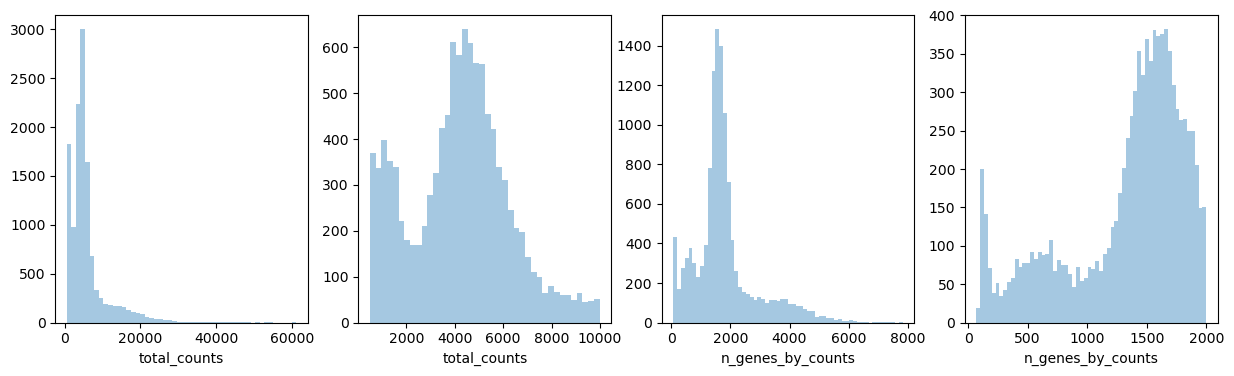

In [5]:
#QC_histogram_ total_counts & genes_by_counts
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 2000], kde=False, bins=60, ax=axs[3])
plt.show()

... storing 'feature_types' as categorical


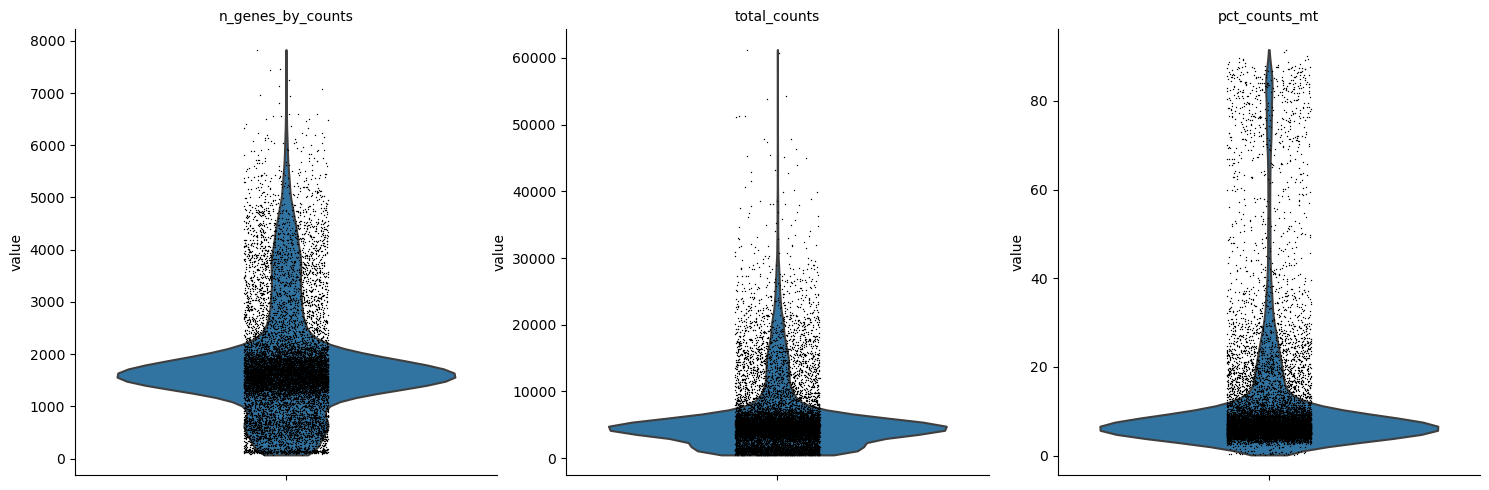

In [6]:
#QC_violin_plot
sc.pl.violin(
    adata, 
    [
     'n_genes_by_counts', 
     'total_counts', 
     'pct_counts_mt'
     ],
    multi_panel=True
)

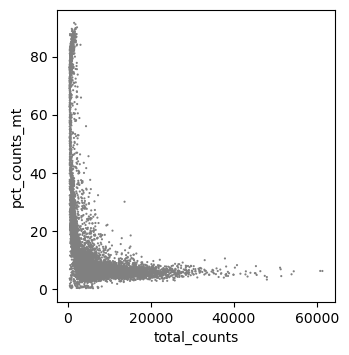

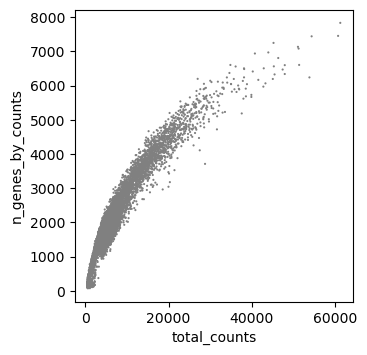

In [7]:
#QC_scatter_plot
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [8]:
#perform UMI based filter
sc.pp.filter_cells(adata, min_counts = 3000)

sc.pp.filter_cells(adata, max_counts=20000)

sc.pp.filter_genes(adata, min_cells=3)

In [9]:
#perform MT gene based filter
adata = adata[adata.obs["pct_counts_mt"] < 20]

# Normalization

In [10]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4) # scale each cell to a common library size
sc.pp.log1p(adata) # log(expression + 1)
adata.raw = adata # freeze the state in `.raw`

In [11]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=4000,
    # subset=True, # to automatically subset to the 4000 genes
    layer="counts",
    flavor="seurat_v3"
)

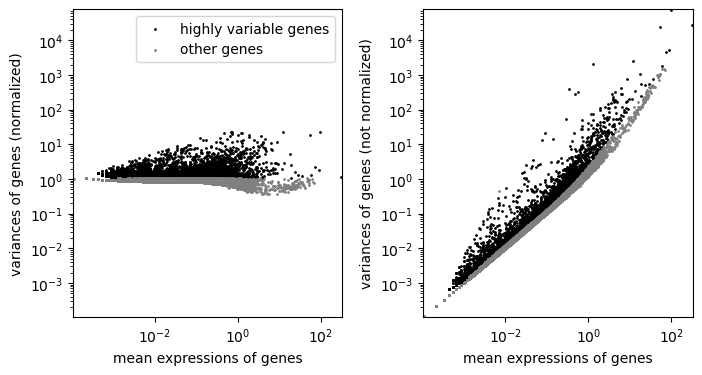

In [12]:
sc.pl.highly_variable_genes(adata, log=True)

In [13]:
# subset to highly variable genes
adata = adata[:, adata.var.highly_variable].copy()

In [14]:
#check anndata structure again
adata

AnnData object with n_obs × n_vars = 9195 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

# PCA, UMAP and clustering 

In [15]:
sc.pp.scale(adata, max_value=10) #normalize genes
sc.tl.pca(adata, svd_solver='arpack')

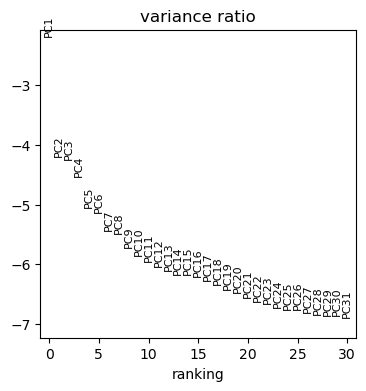

In [16]:
sc.pl.pca_variance_ratio(adata, log=True)

In [17]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30) # compute nearest neighbors, k=10 here and n_pcs=30 according to the variance ratio
sc.tl.umap(adata)

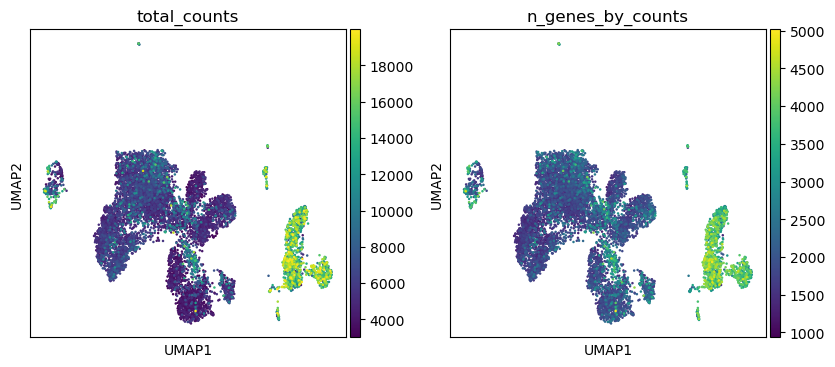

In [18]:
sc.pl.umap(adata, color=['total_counts','n_genes_by_counts'])

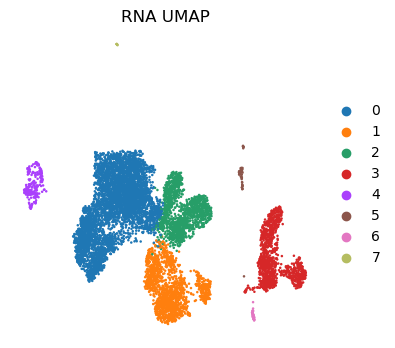

In [56]:
sc.tl.leiden(adata, resolution = 0.1) # resolution is customly chosen
sc.pl.umap(adata, color=['leiden'],title='RNA UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=10)

# Marker genes

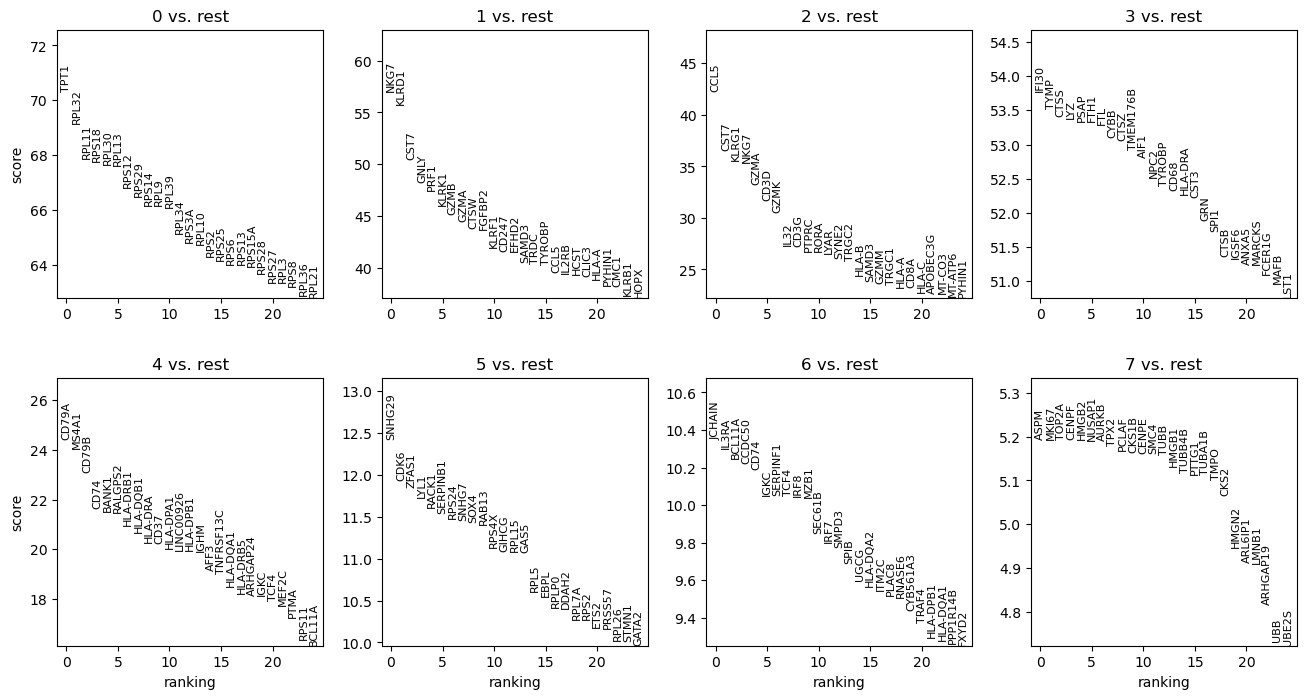

In [57]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [58]:
#convert to dataframe
results = adata.uns['rank_genes_groups']
('0', '1', '2', '3', '4')

out = np.array([[0,0,0,0,0]])
for group in results['names'].dtype.names:
    out = np.vstack((out, np.vstack((results['names'][group],
                                     results['scores'][group],
                                     results['pvals_adj'][group],
                                     results['logfoldchanges'][group],
                                     np.array([group] * len(results['names'][group])).astype('object'))).T))



markers = pd.DataFrame(out[1:], columns = ['Gene', 'scores', 'pval_adj', 'lfc', 'cluster'])

markers = markers[(markers.pval_adj < 0.05) & (abs(markers.lfc) > 1)]

In [59]:
markers

,Gene,scores,pval_adj,lfc,cluster
0,TPT1,70.317413,0.0,1.229925,0
1,RPL32,69.160812,0.0,1.378507,0
2,RPL11,67.872826,0.0,1.223185,0
3,RPS18,67.777176,0.0,1.421112,0
4,RPL30,67.643127,0.0,1.212706,0
...,...,...,...,...,...
176571,RPS12,-4.255156,0.007094,-2.178288,7
176572,RPL9,-4.391217,0.004523,-1.90555,7
176573,PFDN5,-4.479349,0.003388,-1.951357,7
176574,RPL41,-4.498257,0.003287,-1.583786,7


# Cell type annotation
this part can be flexible -- you can either label each cluster manually based on known marker genes or exploit 
avaialbe package to perfored automatic or semi-automatic annotation. 
Here automatic annotation is presented.

In [23]:
#Show all available models that can be downloaded and used.
models.models_description()

👉 Detailed model information can be found at `https://www.celltypist.org/models`


,model,description
0,Immune_All_Low.pkl,immune sub-populations combined from 20 tissue...
1,Immune_All_High.pkl,immune populations combined from 20 tissues of...
2,Adult_Mouse_Gut.pkl,cell types in the adult mouse gut combined fro...
3,Autopsy_COVID19_Lung.pkl,cell types from the lungs of 16 SARS-CoV-2 inf...
4,COVID19_HumanChallenge_Blood.pkl,detailed blood cell states from 16 individuals...
5,COVID19_Immune_Landscape.pkl,immune subtypes from lung and blood of COVID-1...
6,Cells_Fetal_Lung.pkl,cell types from human embryonic and fetal lungs
7,Cells_Intestinal_Tract.pkl,"intestinal cells from fetal, pediatric (health..."
8,Cells_Lung_Airway.pkl,cell populations from scRNA-seq of five locati...
9,Developing_Human_Brain.pkl,cell types from the first-trimester developing...


In [24]:
#Download a specific model, for example, `Healthy_COVID19_PBMC.pkl`.
models.download_models(model = 'Healthy_COVID19_PBMC.pkl')

📂 Storing models in /Users/junjie/.celltypist/data/models
💾 Total models to download: 1
⏩ Skipping [1/1]: Healthy_COVID19_PBMC.pkl (file exists)


In [25]:
#By default (`on_the_fly = False`), all possible models (even those that are not downloaded) are shown.
models.models_description(on_the_fly = True)

👉 Detailed model information can be found at `https://www.celltypist.org/models`


,model,description
0,Healthy_COVID19_PBMC.pkl,peripheral blood mononuclear cell types from h...


In [26]:
#Select the model from the above list. If the `model` argument is not provided, will default to `Immune_All_Low.pkl`.
model = models.Model.load(model = 'Healthy_COVID19_PBMC.pkl')
#The model summary information.
model
#Examine cell types contained in the model.
model.cell_types
#Examine genes/features contained in the model.
model.features

array(['HES4', 'ISG15', 'TTLL10', ..., 'MT-ND4', 'MT-ND5', 'MT-CYB'],
      dtype=object)

In [66]:
#adata.write_h5ad("/Users/junjie/Desktop/pbmc10x.h5ad")

In [29]:
adata

AnnData object with n_obs × n_vars = 9195 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [60]:
predictions = celltypist.annotate(adata, model = 'Healthy_COVID19_PBMC.pkl', majority_voting = True, over_clustering='leiden')

👀 Invalid expression matrix in `.X`, expect log1p normalized expression to 10000 counts per cell; will try the `.raw` attribute
🔬 Input data has 9195 cells and 22072 genes
🔗 Matching reference genes in the model
🧬 3354 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


In [61]:
predictions.predicted_labels

,predicted_labels,over_clustering,majority_voting
AAACCCAAGTTACTCG-1,CD4.Naive,0,CD4.Naive
AAACCCACAACCGTGC-1,NK_16hi,1,NK_16hi
AAACCCACAGCTGTTA-1,CD14_mono,3,CD14_mono
AAACCCAGTAGGAGTC-1,CD4.Naive,0,CD4.Naive
AAACCCAGTTCATCGA-1,CD4.Naive,0,CD4.Naive
...,...,...,...
TTTGTTGGTTACGTAC-1,CD8.EM,0,CD4.Naive
TTTGTTGGTTCGGCTG-1,gdT,2,gdT
TTTGTTGTCACATTGG-1,MAIT,2,gdT
TTTGTTGTCGCAGAGA-1,CD4.Naive,0,CD4.Naive


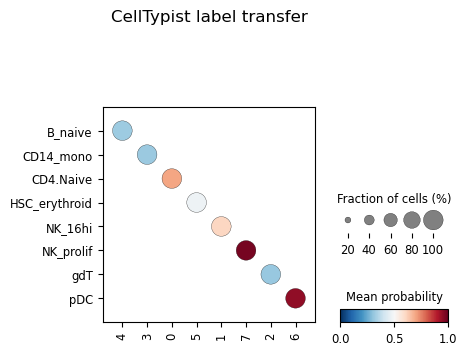

In [62]:
#Quantitatively compares the CellTypist prediction result with the cell types (or clusters) pre-defined 
celltypist.dotplot(predictions, use_as_reference = 'leiden', use_as_prediction = 'majority_voting')

# Differential gene expression 
different approaches to do visulization are introduced

In [65]:
adata.obs['cell_type']=predictions.predicted_labels['majority_voting']

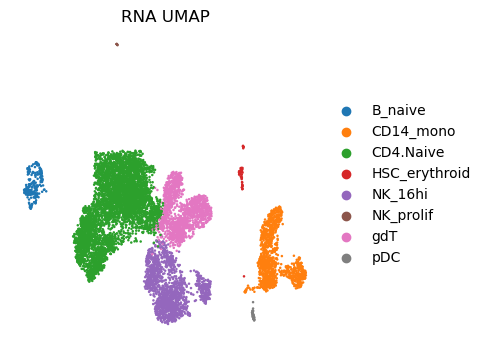

In [67]:
sc.pl.umap(adata, color=['cell_type'],title='RNA UMAP',
           frameon=False, legend_fontweight='normal', legend_fontsize=10)

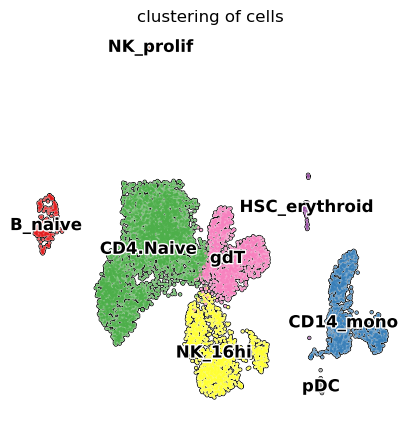

In [70]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color='cell_type', add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2,frameon=False,
               title='clustering of cells', palette='Set1')

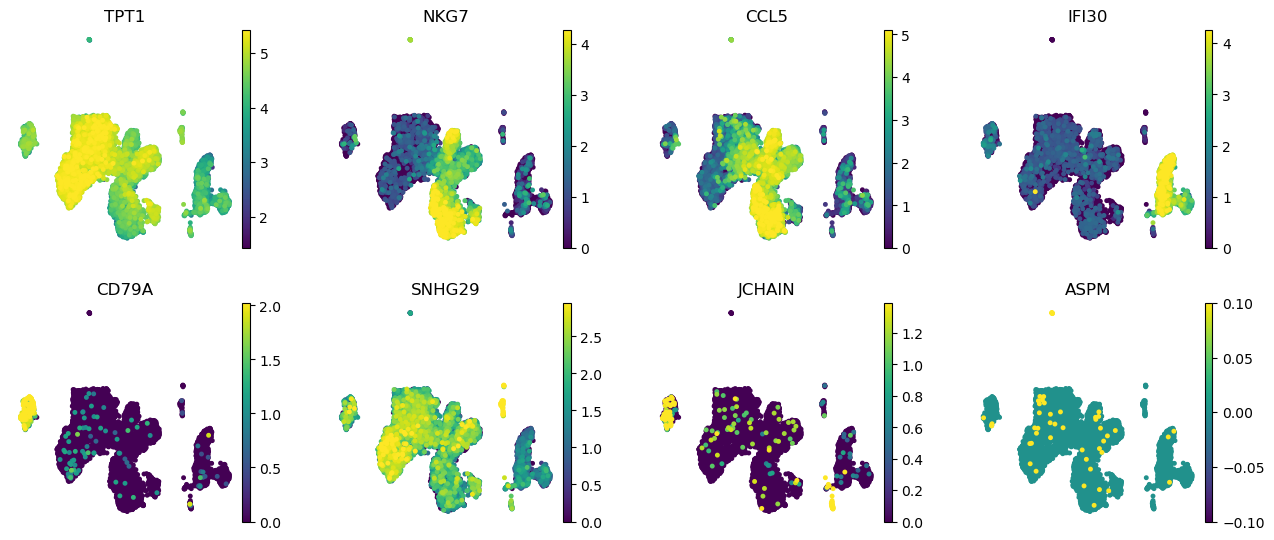

In [73]:
# rc_context is used for the figure size, in this case 3x3, show expression of each marker
with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.umap(adata, color=['TPT1', 'NKG7', 'CCL5', 'IFI30', 'CD79A', 'SNHG29', 'JCHAIN', 'ASPM'], s=50, frameon=False, ncols=4, vmax='p99')

In [78]:
marker_genes_dict = {
    'B-cell': ['CD79A', 'MS4A1'],
    'Dendritic': ['FCER1A', 'CST3'],
    'Monocytes': ['FCGR3A'],
    'NK': ['GNLY', 'NKG7'],
    'Other': ['IGLL1'],
    'T-cell': ['CD3D'],
}

categories: B_naive, CD14_mono, CD4.Naive, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


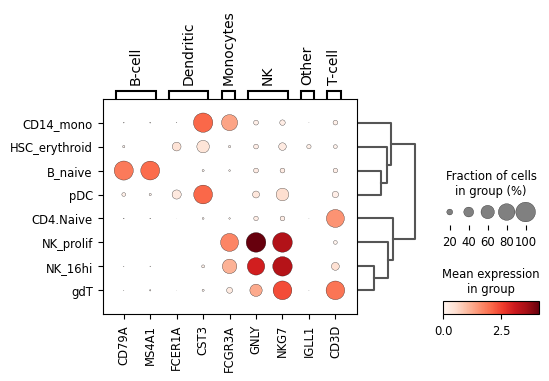

In [79]:
#dotplot
sc.pl.dotplot(adata, marker_genes_dict, 'cell_type', dendrogram=True)

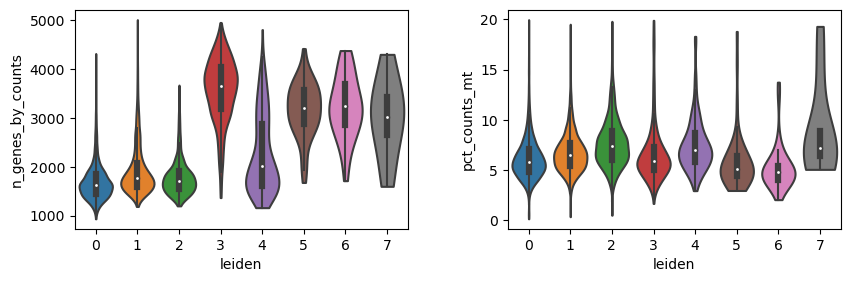

In [82]:
with rc_context({'figure.figsize': (4.5, 3)}):
    sc.pl.violin(adata, ['n_genes_by_counts', 'pct_counts_mt'], groupby='leiden', stripplot=False, inner='box')  # use stripplot=False to remove the internal dots, inner='box' adds a boxplot inside violins

categories: B_naive, CD14_mono, CD4.Naive, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


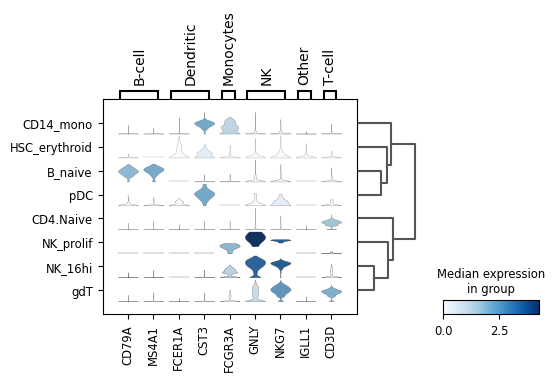

In [83]:
#violin plot
ax = sc.pl.stacked_violin(adata, marker_genes_dict, groupby='cell_type', swap_axes=False, dendrogram=True)

categories: B_naive, CD14_mono, CD4.Naive, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


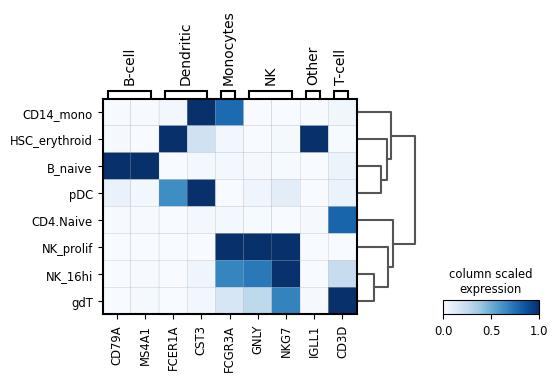

In [87]:
#matrixplot
sc.pl.matrixplot(adata, marker_genes_dict, 'cell_type', dendrogram=True, cmap='Blues', standard_scale='var', colorbar_title='column scaled\nexpression')

categories: B_naive, CD14_mono, CD4.Naive, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


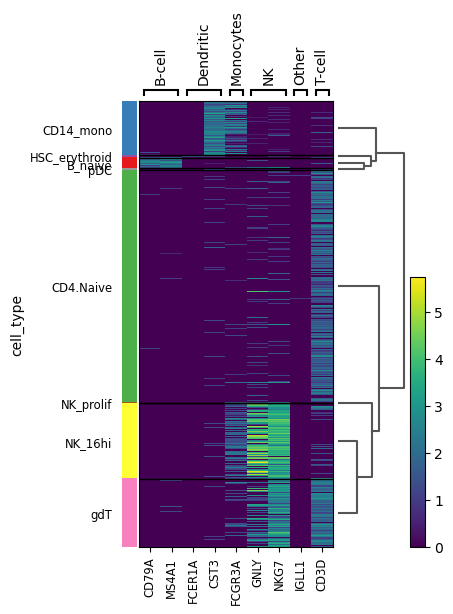

In [93]:
#heatmap
ax = sc.pl.heatmap(adata, marker_genes_dict, groupby='cell_type', cmap='viridis', dendrogram=True)

categories: B_naive, CD14_mono, CD4.Naive, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


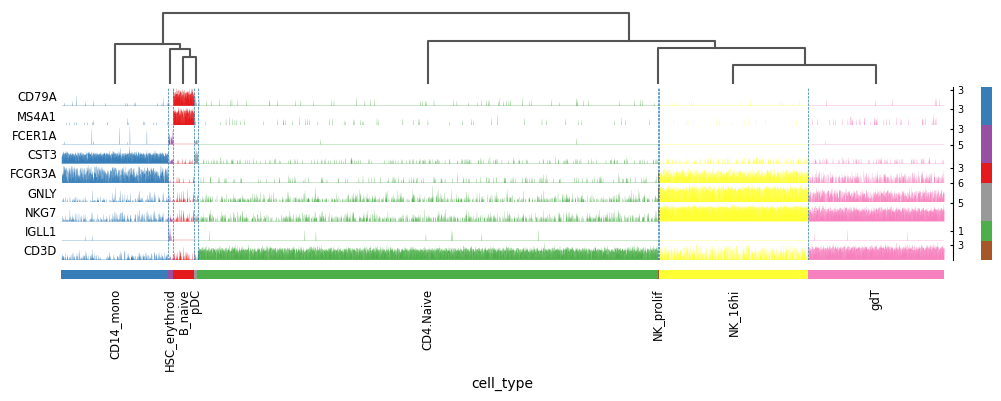

In [96]:
#trackplot
ax = sc.pl.tracksplot(adata, marker_genes_dict, groupby='cell_type', dendrogram=True)

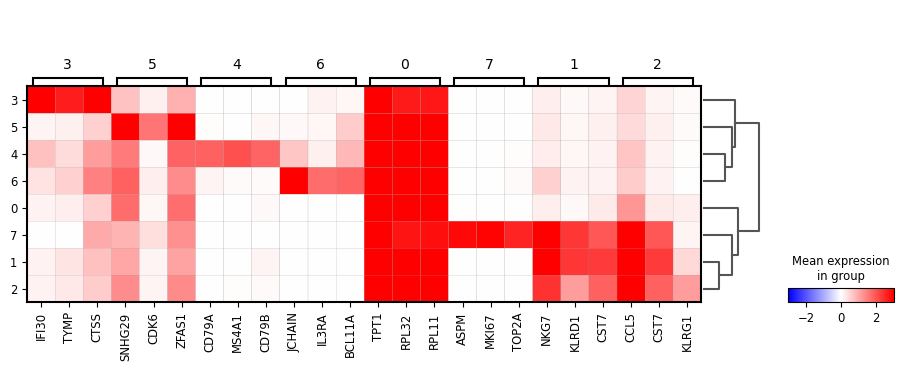

In [126]:
#in case with no prior knowledge 
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=3, vmin=-3, vmax=3, cmap='bwr')

In [149]:
# compute hierarchical clustering using PCs (several distance metrics and linkage methods are available).
sc.tl.dendrogram(adata, 'cell_type')

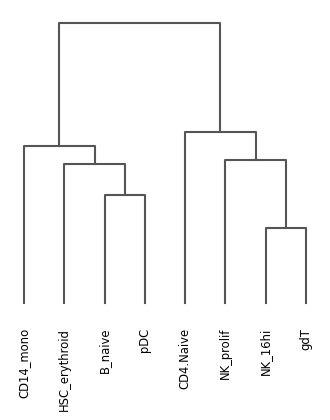

In [150]:
ax = sc.pl.dendrogram(adata, 'cell_type')

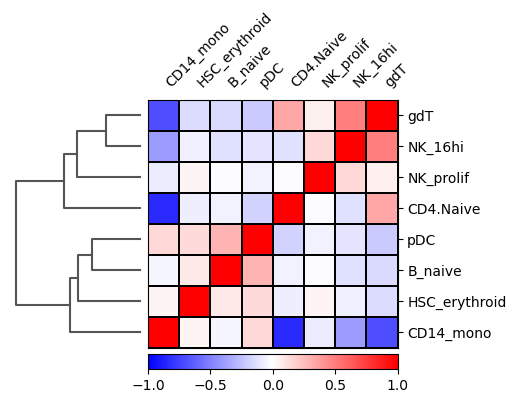

In [151]:
ax = sc.pl.correlation_matrix(adata, 'cell_type', figsize=(5,3.5))

# Single cell PLA data analysis

In [102]:
#load PLA data 
pla = pd.read_csv('10x_PLA_count_matrix.txt.gz', sep="\t",index_col=0)

In [103]:
#check structure, note that here the row is PLA pair and the column is cell/spot
pla.shape

(1348, 12577)

In [104]:
#cell filter based on mRNA QC resullt
pla = pla.transpose().loc[adata.obs.index,:]

In [105]:
#check again 
pla.shape

(9195, 1348)

In [110]:
#construct PLA object and generate protein count matrix 
pla_obj = PC.plaObject(pla.transpose())
pla_obj.calculateProteinCount()

In [114]:
pla_obj.protein_count.head()

,AAACCCAAGTTACTCG-1,AAACCCACAACCGTGC-1,AAACCCACAGCTGTTA-1,AAACCCAGTAGGAGTC-1,AAACCCAGTTCATCGA-1,AAACCCATCCTCAGAA-1,AAACCCATCGACGCTG-1,AAACCCATCGAGTCCG-1,AAACCCATCTGTCAGA-1,AAACGAAAGAGACAAG-1,...,TTTGTTGAGGTAGCCA-1,TTTGTTGCACATAGCT-1,TTTGTTGCATTCAGCA-1,TTTGTTGGTACAAACA-1,TTTGTTGGTCTGCCTT-1,TTTGTTGGTTACGTAC-1,TTTGTTGGTTCGGCTG-1,TTTGTTGTCACATTGG-1,TTTGTTGTCGCAGAGA-1,TTTGTTGTCTACCTTA-1
41-BB,0,0,7,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,2,0,0
B7,1,0,12,1,0,1,2,0,0,0,...,0,0,0,0,0,2,0,0,0,0
CCR5,3,4,34,3,1,1,9,2,0,1,...,3,5,0,2,1,3,7,3,1,3
CCR6,5,0,6,14,0,5,1,9,0,2,...,0,1,2,0,14,2,3,1,1,3
CCR7,6,1,21,2,35,3,4,0,2,3,...,2,5,3,2,2,11,0,1,25,1


In [115]:
pla_obj.pla_count.head()

,AAACCCAAGTTACTCG-1,AAACCCACAACCGTGC-1,AAACCCACAGCTGTTA-1,AAACCCAGTAGGAGTC-1,AAACCCAGTTCATCGA-1,AAACCCATCCTCAGAA-1,AAACCCATCGACGCTG-1,AAACCCATCGAGTCCG-1,AAACCCATCTGTCAGA-1,AAACGAAAGAGACAAG-1,...,TTTGTTGAGGTAGCCA-1,TTTGTTGCACATAGCT-1,TTTGTTGCATTCAGCA-1,TTTGTTGGTACAAACA-1,TTTGTTGGTCTGCCTT-1,TTTGTTGGTTACGTAC-1,TTTGTTGGTTCGGCTG-1,TTTGTTGTCACATTGG-1,TTTGTTGTCGCAGAGA-1,TTTGTTGTCTACCTTA-1
PLA_pair,,,,,,,,,,,,,,,,,,,,,
41-BB:41-BB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41-BB:B7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41-BB:CCR5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41-BB:CCR6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41-BB:CCR7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [117]:
#construct PLA and protein Anndata object for downstream analysis
adata_pla = sc.AnnData(X=pla)
adata_protein = sc.AnnData(X=pla_obj.protein_count.transpose())

In [121]:
#check pla anndata structure
adata_pla

AnnData object with n_obs × n_vars = 9195 × 1348

In [122]:
#check protein anndata structure
adata_protein

AnnData object with n_obs × n_vars = 9195 × 38

In [124]:
#transfer cell type label from RNA to protein and PLA 
adata_pla.obs['cell_type'] = adata.obs['cell_type']
adata_protein.obs['cell_type'] = adata.obs['cell_type']

In [128]:
#similar preprocess to PLA data
adata_pla.layers["counts"] = adata_pla.X.copy() # preserve counts
sc.pp.normalize_total(adata_pla, target_sum=1e4) # scale each cell to a common library size
sc.pp.log1p(adata_pla) # log(expression + 1)
adata_pla.raw = adata_pla # freeze the state in `.raw`
sc.pp.scale(adata_pla, max_value=10)
sc.tl.pca(adata_pla, svd_solver='arpack')

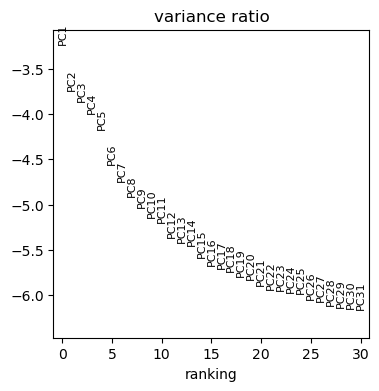

In [129]:
sc.pl.pca_variance_ratio(adata_pla, log=True)

In [131]:
sc.pp.neighbors(adata_pla, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata_pla)
sc.tl.leiden(adata_pla,key_added='clusters',resolution=0.2)

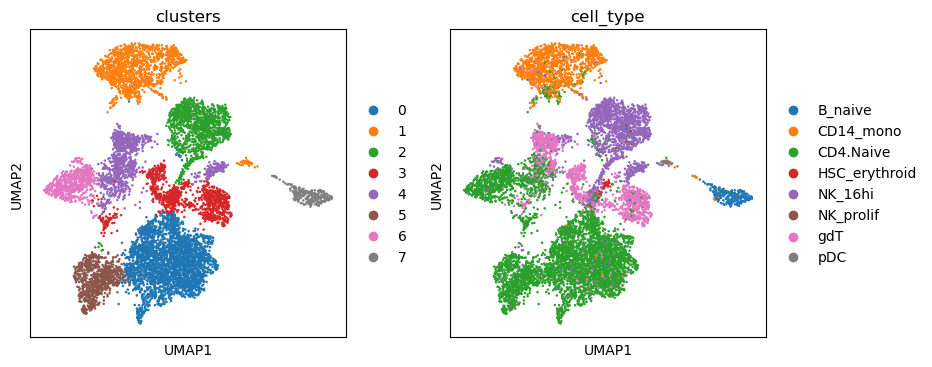

In [133]:
sc.pl.umap(adata_pla,color=['clusters','cell_type'])

In [134]:
sc.tl.rank_genes_groups(adata_pla, groupby='clusters', method='wilcoxon')

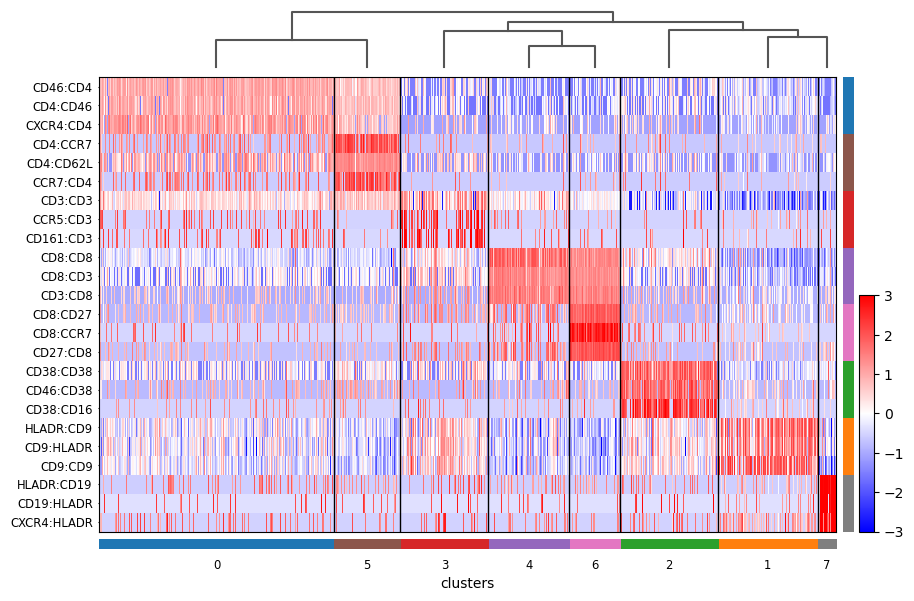

In [135]:
sc.pl.rank_genes_groups_heatmap(adata_pla, n_genes=3,  swap_axes=True, vmin=-3, vmax=3, cmap='bwr',figsize=(10,7), show=False);

In [145]:
sc.tl.rank_genes_groups(adata_pla, groupby='cell_type', method='wilcoxon')

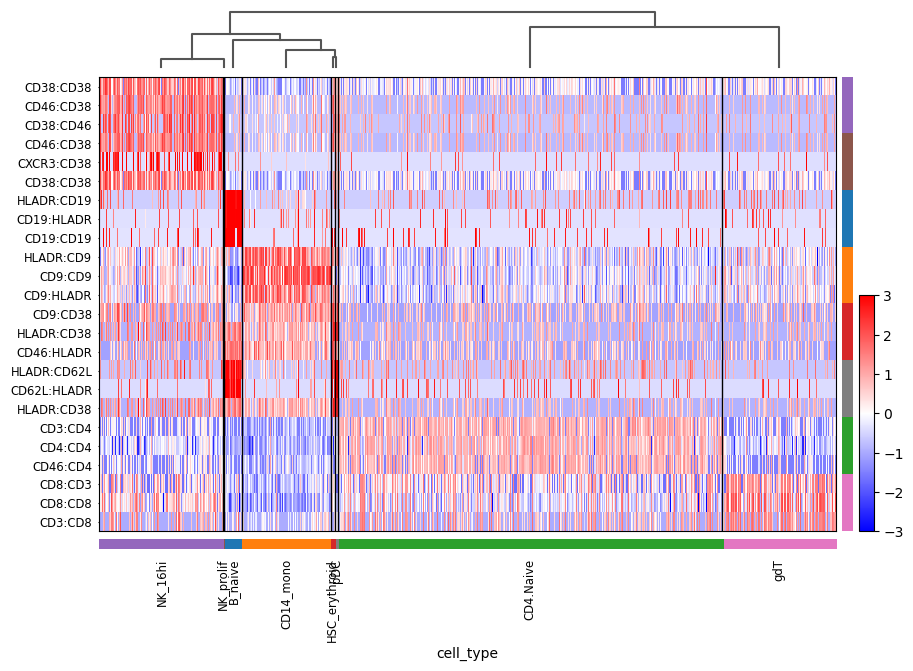

In [146]:
sc.pl.rank_genes_groups_heatmap(adata_pla, n_genes=3,  swap_axes=True, vmin=-3, vmax=3, cmap='bwr',figsize=(10,7), show=False);

In [136]:
#similar process to protein data
adata_protein.layers["counts"] = adata_protein.X.copy() # preserve counts
sc.pp.normalize_total(adata_protein, target_sum=1e4) # scale each cell to a common library size
sc.pp.log1p(adata_protein) # log(expression + 1)
adata_protein.raw = adata_protein # freeze the state in `.raw`
sc.pp.scale(adata_protein, max_value=10)
sc.tl.pca(adata_protein, svd_solver='arpack')

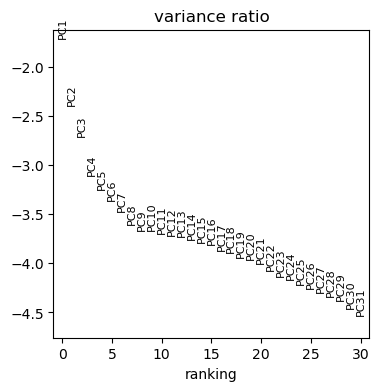

In [137]:
sc.pl.pca_variance_ratio(adata_protein, log=True)

In [140]:
sc.pp.neighbors(adata_protein, n_neighbors=10, n_pcs=10)
sc.tl.umap(adata_protein)
sc.tl.leiden(adata_protein,key_added='clusters',resolution=0.5)

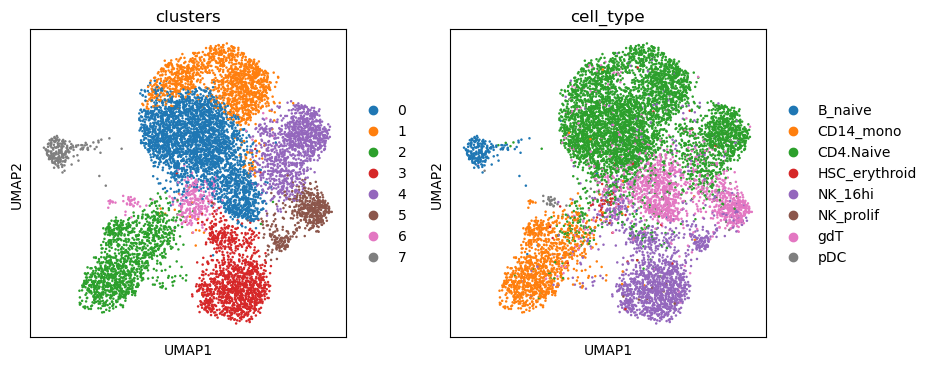

In [141]:
sc.pl.umap(adata_protein,color=['clusters','cell_type'])

In [142]:
sc.tl.rank_genes_groups(adata_protein, groupby='clusters', method='wilcoxon')

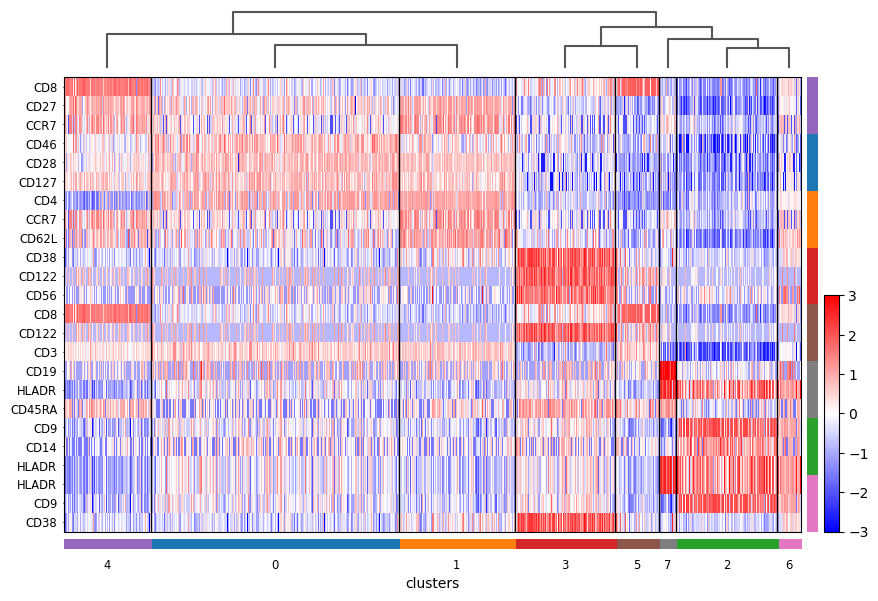

In [144]:
sc.pl.rank_genes_groups_heatmap(adata_protein, n_genes=3, swap_axes=True, vmin=-3, vmax=3, cmap='bwr',figsize=(10,7), show=False);

In [147]:
sc.tl.rank_genes_groups(adata_protein, groupby='cell_type', method='wilcoxon')

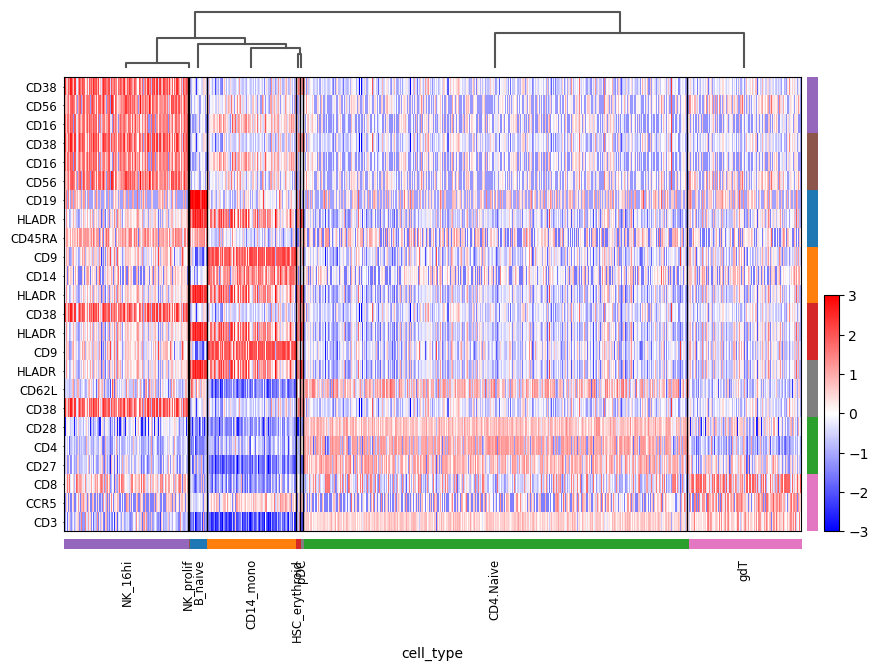

In [148]:
sc.pl.rank_genes_groups_heatmap(adata_protein, n_genes=3, swap_axes=True, vmin=-3, vmax=3, cmap='bwr',figsize=(10,7), show=False);